# Betting on Esports
## Modeling II
### Jonathan Pena
### Capstone Notebook Part 3
# Feature Engineering

The last notebook of our project is here. We will create some features that allow us to predict the outcome of future games, as well as implement various classification models such as Random Forest and XGBoost.

Let's first import all the libraries we will need in the notebook.

In [1]:
# importing libraries
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows',None)
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing and transformation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Importing models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# model evaluation
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve, roc_auc_score

# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

# ignore future warnings
import warnings
warnings.filterwarnings('ignore')

## Loading the Dataset

As a first step, load the data into a dataframe and check the information it contains.

In [2]:
# Loading the data into a dataframe.
lol_cleaned = pd.read_csv('data/lol_cleaned.csv').reset_index().drop(columns=['index', 'Unnamed: 0'])

# Convert 'Date' column to datetime type.
lol_cleaned['date'] = pd.to_datetime(lol_cleaned['date'])

# check some rows from the dataframe
lol_cleaned.head()

,gameid,date,side,team,gamelength,result,kills,deaths,firstblood,dragons,barons,towers,wcpm,controlwardsbought,totalgold,minionkills,cspm
0,6909-9183,2021-01-09 09:22:04,Blue,Top Esports,2050,0,3,9,1.0,2.0,0.0,3.0,2.4293,40.0,54617,987.0,36.0000
1,6909-9183,2021-01-09 09:22:04,Red,Suning,2050,1,9,3,0.0,2.0,1.0,6.0,1.7854,46.0,60520,947.0,35.5610
2,6909-9184,2021-01-09 10:16:20,Blue,Top Esports,2241,0,16,27,0.0,3.0,2.0,6.0,1.9545,42.0,69692,957.0,33.2798
3,6909-9184,2021-01-09 10:16:20,Red,Suning,2241,1,27,17,1.0,2.0,0.0,7.0,1.4726,49.0,70269,939.0,31.8876
4,6910-9189,2021-01-09 11:30:25,Blue,Oh My God,1887,0,4,15,1.0,1.0,0.0,3.0,1.4944,32.0,51145,848.0,33.8951


## Feature Creation

As we saw in the last notebook, the features in the dataframe allow us to identify the outcome of a game that has already ended. The goal is to predict future games, which means to bet on upcoming games. To achieve our goal, we need features that help us create a team profile based on previous games. In order to develop a KPI for the next game, we selected some of the indicators from the last ten games.

The following features were created:
- Kills per Minute: This feature divides the total number of kills made by a team in the last 10 games by the length of those games. To calculate this KPI, two functions were created: **team_kpm** and **kpm_past_matches**.
- Gold per Minute feature divides the total gold made by a team in the last 10 games by the length of those games. To calculate this KPI, two functions have been created: **team_gpm** and **gpm_past_matches**.
- Minion Kills Per Minute: This feature divides the number of Minions kills made by a team in the last 10 games by the total length of those games. In order to calculate this KPI, two functions were created: **team_cspm** and **cspm_past_matches**.
- Towers Destroyed per Minute: This feature divides the total number of Towers destroyed by a team in the last 10 games by the total length of the games. To calculate this KPI, two functions were created: **team_tpm** and **tpm_past_match**.

### Kills per MInute

In [3]:
# team_kpm definition
def team_kpm(df):
    
    ''' This function calculate the Kills per minute KPI using the columns kills and gamelength
    from the given dataframe'''
    
    kills = int(df['kills'].sum())
    gamelength = int(df['gamelength'].sum())/60
    
    kpm = kills/gamelength
    
    return kpm 

# kpm_past_matches definition
def kpm_past_matches(df):
    
    ''' This fucntion filter the information for the last 10 matches of a team
    and them use the team_kpm fucntion to return the KPI for that team'''
    
    team = df['team']
    date = df['date']
    team_matches = lol_cleaned[lol_cleaned['team'] == team]
    last_matches = team_matches[team_matches['date'] < date ].sort_values(by = 'date', ascending = False).iloc[0:10,:]
    current_match = team_matches[team_matches['date'] == date ]
    
    if last_matches.shape[0] == 0:
        kpm = team_kpm(current_match)
    elif last_matches.shape[0] ==1:
        kpm1 = team_kpm(last_matches)
        kpm2 = team_kpm(current_match)
        kpm = (kpm1 + kpm2)/2
    else:
        kpm = team_kpm(last_matches)
    
    return kpm

### Gold per Minute

In [4]:
# team_gpm definition
def team_gpm(df):
    
    ''' This function calculate the Gold per minute KPI using the columns totalgold and gamelength
    from the given dataframe'''
    
    gold = int(df['totalgold'].sum())
    gamelength = int(df['gamelength'].sum())/60
    
    gpm = gold/gamelength
    
    return gpm

# gpm_past_matches definition
def gpm_past_matches(df):
    
    ''' This fucntion filter the information for the last 10 matches of a team
    and them use the team_gpm fucntion to return the KPI for that team'''
    
    team = df['team']
    date = df['date']
    team_matches = lol_cleaned[lol_cleaned['team'] == team]
    last_matches = team_matches[team_matches['date'] < date ].sort_values(by = 'date', ascending = False).iloc[0:10,:]
    current_match = team_matches[team_matches['date'] == date ]
    
    if last_matches.shape[0] == 0:
        gpm = team_gpm(current_match)
    elif last_matches.shape[0] ==1:
        gpm1 = team_gpm(last_matches)
        gpm2 = team_gpm(current_match)
        gpm = (gpm1 + gpm2)/2
    else:
        gpm = team_gpm(last_matches)
    
    return gpm

### Minion Kills per MInute

In [5]:
# team_cspm definition
def team_cspm(df):
    
    ''' This function calculate the Minion Kills per minute KPI using the columns minionkills and gamelength
    from the given dataframe'''
    
    minionkills = int(df['minionkills'].sum())
    gamelength = int(df['gamelength'].sum())/60
    
    cspm = minionkills/gamelength
    
    return cspm

# cspm_past_matches definition
def cspm_past_matches(df):
    
    ''' This fucntion filter the information for the last 10 matches of a team
    and them use the team_cspm fucntion to return the KPI for that team'''
    
    team = df['team']
    date = df['date']
    team_matches = lol_cleaned[lol_cleaned['team'] == team]
    last_matches = team_matches[team_matches['date'] < date ].sort_values(by = 'date', ascending = False).iloc[0:10,:]
    current_match = team_matches[team_matches['date'] == date ]
    
    if last_matches.shape[0] == 0:
        cspm = team_cspm(current_match)
    elif last_matches.shape[0] ==1:
        cspm1 = team_cspm(last_matches)
        cspm2 = team_cspm(current_match)
        cspm = (cspm1 + cspm2)/2
    else:
        cspm = team_cspm(last_matches)
    
    return cspm

### Towers Destroyed per minute

In [6]:
# team_tpm definition
def team_tpm(df):
    
    ''' This function calculate the Towers Destroyed per minute KPI using the columns towers and gamelength
    from the given dataframe'''
    
    towers = int(df['towers'].sum())
    gamelength = int(df['gamelength'].sum())/60
    
    tpm = towers/gamelength
    
    return tpm

# tpm_past_matches definition
def tpm_past_matches(df):
    
    ''' This fucntion filter the information for the last 10 matches of a team
    and them use the team_tpm fucntion to return the KPI for that team'''
    
    team = df['team']
    date = df['date']
    team_matches = lol_cleaned[lol_cleaned['team'] == team]
    last_matches = team_matches[team_matches['date'] < date ].sort_values(by = 'date', ascending = False).iloc[0:10,:]
    current_match = team_matches[team_matches['date'] == date ]
    
    if last_matches.shape[0] == 0:
        tpm = team_tpm(current_match)
    elif last_matches.shape[0] ==1:
        tpm1 = team_tpm(last_matches)
        tpm2 = team_tpm(current_match)
        tpm = (tpm1 + tpm2)/2
    else:
        tpm = team_tpm(last_matches)
    
    return tpm

### New Feature Implementation

Now that we have defined our new features to predict a future game, let's build our dataframe. First, we will select the columns that we need from our cleaned dataframe and create a new dataframe called new_feat.

In [7]:
# create new_feat dataframe
new_feat = lol_cleaned[['gameid', 'side', 'team', 'result']]
new_feat.head()

,gameid,side,team,result
0,6909-9183,Blue,Top Esports,0
1,6909-9183,Red,Suning,1
2,6909-9184,Blue,Top Esports,0
3,6909-9184,Red,Suning,1
4,6910-9189,Blue,Oh My God,0


We will now create the new features by applying the function we created to the cleaned dataframe and adding the result to the new_feat dataframe.

In [8]:
# create a new column for each new feature
# apply the new KPI functions row wise
new_feat['kpm'] = lol_cleaned.apply(kpm_past_matches, axis=1)
new_feat['gpm'] = lol_cleaned.apply(gpm_past_matches, axis=1)
new_feat['cspm'] = lol_cleaned.apply(cspm_past_matches, axis=1)
new_feat['tpm'] = lol_cleaned.apply(tpm_past_matches, axis=1)

In [9]:
# check the first 20 rows of the new_feat dataframe
new_feat.head(20)

,gameid,side,team,result,kpm,gpm,cspm,tpm
0,6909-9183,Blue,Top Esports,0,0.087805,1598.546341,28.887805,0.087805
1,6909-9183,Red,Suning,1,0.263415,1771.317073,27.717073,0.175610
2,6909-9184,Blue,Top Esports,0,0.258093,1732.231671,27.255147,0.124224
3,6909-9184,Red,Suning,1,0.493153,1826.341268,26.428818,0.181513
4,6910-9189,Blue,Oh My God,0,0.127186,1626.232114,26.963434,0.095390
5,6910-9189,Red,EDward Gaming,1,0.476948,1931.255962,28.934817,0.286169
6,6910-9190,Blue,EDward Gaming,0,0.357877,1775.448876,27.765916,0.172935
7,6910-9190,Red,Oh My God,1,0.332250,1777.563818,27.138433,0.211874
8,6910-9191,Blue,Oh My God,0,0.338722,1782.340262,27.143957,0.215550
9,6910-9191,Red,EDward Gaming,1,0.354119,1770.531178,27.729022,0.169361


We have a dataframe with new fetures, but we must fix the matches according to the gameid. Because of that, we will split the dataset in two: blue side and red side, and then join them by gameid.

In [10]:
# divide the clean dataset into red and blue side.
blue_df = new_feat[new_feat['side']=='Blue'].set_index('gameid')
red_df = new_feat[new_feat['side']=='Red'].set_index('gameid')

# join the blue_df and red_df into matches_df by the index that is the gameid
matches_df = blue_df.join(red_df, lsuffix='_blue', rsuffix='_red')

In [11]:
# check some rows from the dataframe
matches_df.head()

,side_blue,team_blue,result_blue,kpm_blue,gpm_blue,cspm_blue,tpm_blue,side_red,team_red,result_red,kpm_red,gpm_red,cspm_red,tpm_red
gameid,,,,,,,,,,,,,,
6909-9183,Blue,Top Esports,0,0.087805,1598.546341,28.887805,0.087805,Red,Suning,1,0.263415,1771.317073,27.717073,0.175610
6909-9184,Blue,Top Esports,0,0.258093,1732.231671,27.255147,0.124224,Red,Suning,1,0.493153,1826.341268,26.428818,0.181513
6910-9189,Blue,Oh My God,0,0.127186,1626.232114,26.963434,0.095390,Red,EDward Gaming,1,0.476948,1931.255962,28.934817,0.286169
6910-9190,Blue,EDward Gaming,0,0.357877,1775.448876,27.765916,0.172935,Red,Oh My God,1,0.332250,1777.563818,27.138433,0.211874
6910-9191,Blue,Oh My God,0,0.338722,1782.340262,27.143957,0.215550,Red,EDward Gaming,1,0.354119,1770.531178,27.729022,0.169361


After joining the datasets we have some duplicate columns like `side_blue` and `side_red`, as well as some we don't need anymore, such as `result_blue`. These will be removed.

In [12]:
# drop unnecessary columns
matches_df = matches_df.drop(columns=['side_blue', 'side_red', 'result_blue'])

# reset dataframe index
matches_df.reset_index(inplace=True)

# drop gameid column
matches_df.drop(columns=['gameid'], inplace=True)

# check some rows of the dataframe
matches_df.head()

,team_blue,kpm_blue,gpm_blue,cspm_blue,tpm_blue,team_red,result_red,kpm_red,gpm_red,cspm_red,tpm_red
0,Top Esports,0.087805,1598.546341,28.887805,0.087805,Suning,1,0.263415,1771.317073,27.717073,0.175610
1,Top Esports,0.258093,1732.231671,27.255147,0.124224,Suning,1,0.493153,1826.341268,26.428818,0.181513
2,Oh My God,0.127186,1626.232114,26.963434,0.095390,EDward Gaming,1,0.476948,1931.255962,28.934817,0.286169
3,EDward Gaming,0.357877,1775.448876,27.765916,0.172935,Oh My God,1,0.332250,1777.563818,27.138433,0.211874
4,Oh My God,0.338722,1782.340262,27.143957,0.215550,EDward Gaming,1,0.354119,1770.531178,27.729022,0.169361


## Modeling II

In this section, we are going to build a number of classification models using the features created, and create a GridSearchCV that will optimize the hyperparameters in each model.

In the first step, we separate our independent variable from our target that is the result for the red team: 1 if it is a win, 0 if it is a loss.

In [13]:
# Separate the data into X and y variables
# X is the data containing the independent variables.
# y is the target.  The dependent variable.
X = matches_df.drop(columns= ['result_red'])
y = matches_df['result_red']

Next, we will encode the teams with dummy variables and concatenate them with our X data frame. Finally, we remove the `team_blue` and `team_red` columns.

In [14]:
# create dummies for group_size, Reviewer_Nationality and trip_class
team_blue_dummies = pd.get_dummies(X[['team_blue']]).drop(columns='team_blue_unknown team')
X = pd.concat([X, team_blue_dummies], axis=1)

team_red_dummies = pd.get_dummies(X[['team_red']]).drop(columns='team_red_unknown team')
X = pd.concat([X, team_red_dummies], axis=1)

X = X.drop(columns=['team_blue', 'team_red'])

In [15]:
# Checking the shape of X
X.shape, y.shape

((10826, 967), (10826,))

Our X dataframe now contains the new features created, and our y dataframe contains the game result for the red team. We will split both dataframes into train and test dataframes to build our model. 

In [16]:
# split the data in train and test dataframes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)

In [17]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7578, 967), (3248, 967), (7578,), (3248,))

Even though our target is balanced, we still use the stratify parameter to maintain balance. The train set makes up 70% of the total dataset, while the test set makes up 30%. Our model will be optimized with GridSearchCV and a pipeline to avoid any mistakes in handling data.  

The model's hyperparameters are tuned with validation sets. Its purpose is to provide an unbiased evaluation of the model's performance. As the model has not been fitted to the data, it should not overfit when using the fit parameter. Both the training and validation sets are used to tune the model's parameters. We may be overfitting to both sets while the test set is meant to provide an unbiased estimate of the model's performance. This is why the test set should never be used to adjust parameters since it is fixed and unchangeable until we fit our final model to it. 

In [18]:
# estimators for the pipe
estimators = [
    ('normalise', StandardScaler(with_mean=False)),
    ('model',LogisticRegression)
]

pipe = Pipeline(estimators)

We will optimize the following hyperparameters:
- **Logistic Regression** 
    - C: the inverse of regularization strength. By default, the Logistic Regression solver is lbfgs and it only supports L2-penalty.
- **DecisionTreeClassifier**
    - max_depth: The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.
- **KNeighborsClassifier**
    - n_neighbors: Number of neighbors to use by default for kneighbors queries.
- **XGBClassifier**
    - n_estimators: Number of gradient boosted trees. Equivalent to number of boosting rounds.
    - max_depth: Maximum tree depth for base learners.
- **RandomForestClassifier**
    - n_estimators: The number of trees in the forest.

We will also set the GridSearchCV cv parameter to 5 to perform a 5-fold cross validation.

In [34]:
# create a pamater grid for 3 different models
param_grid = [
            {
                'normalise': [None],
                'model': [DecisionTreeClassifier()], 
                'model__max_depth': range(1, 10),
            },
            {
                'normalise': [StandardScaler()],
                'model': [LogisticRegression()], 
                'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
            },
             {
                'normalise': [StandardScaler()],
                'model': [KNeighborsClassifier()], 
                'model__n_neighbors': range(1, 40, 2),
            },
            {
                'model':  [XGBClassifier()],
                'normalise': [StandardScaler()],
                'model__n_estimators':np.arange(1, 100, 10),
                'model__max_depth':np.arange(1,5)
            },
            {
                'model':  [RandomForestClassifier()],
                'normalise': [StandardScaler()],
                'model__n_estimators':np.arange(1, 100, 10)
            }
            
] 

grid = GridSearchCV(pipe, param_grid, cv=5, verbose=2) 

fittedgrid = grid.fit(X_train, y_train)

Fitting 5 folds for each of 85 candidates, totalling 425 fits
[CV] END model=DecisionTreeClassifier(), model__max_depth=1, normalise=None; total time=   0.0s
[CV] END model=DecisionTreeClassifier(), model__max_depth=1, normalise=None; total time=   0.0s
[CV] END model=DecisionTreeClassifier(), model__max_depth=1, normalise=None; total time=   0.0s
[CV] END model=DecisionTreeClassifier(), model__max_depth=1, normalise=None; total time=   0.0s
[CV] END model=DecisionTreeClassifier(), model__max_depth=1, normalise=None; total time=   0.0s
[CV] END model=DecisionTreeClassifier(), model__max_depth=2, normalise=None; total time=   0.0s
[CV] END model=DecisionTreeClassifier(), model__max_depth=2, normalise=None; total time=   0.0s
[CV] END model=DecisionTreeClassifier(), model__max_depth=2, normalise=None; total time=   0.0s
[CV] END model=DecisionTreeClassifier(), model__max_depth=2, normalise=None; total time=   0.0s
[CV] END model=DecisionTreeClassifier(), model__max_depth=2, normalise=Non

[CV] END model=KNeighborsClassifier(), model__n_neighbors=3, normalise=StandardScaler(); total time=   0.8s
[CV] END model=KNeighborsClassifier(), model__n_neighbors=5, normalise=StandardScaler(); total time=   0.9s
[CV] END model=KNeighborsClassifier(), model__n_neighbors=5, normalise=StandardScaler(); total time=   0.9s
[CV] END model=KNeighborsClassifier(), model__n_neighbors=5, normalise=StandardScaler(); total time=   0.9s
[CV] END model=KNeighborsClassifier(), model__n_neighbors=5, normalise=StandardScaler(); total time=   0.8s
[CV] END model=KNeighborsClassifier(), model__n_neighbors=5, normalise=StandardScaler(); total time=   0.9s
[CV] END model=KNeighborsClassifier(), model__n_neighbors=7, normalise=StandardScaler(); total time=   1.0s
[CV] END model=KNeighborsClassifier(), model__n_neighbors=7, normalise=StandardScaler(); total time=   0.9s
[CV] END model=KNeighborsClassifier(), model__n_neighbors=7, normalise=StandardScaler(); total time=   0.8s
[CV] END model=KNeighborsCla

[CV] END model=KNeighborsClassifier(), model__n_neighbors=35, normalise=StandardScaler(); total time=   1.1s
[CV] END model=KNeighborsClassifier(), model__n_neighbors=35, normalise=StandardScaler(); total time=   0.8s
[CV] END model=KNeighborsClassifier(), model__n_neighbors=35, normalise=StandardScaler(); total time=   0.8s
[CV] END model=KNeighborsClassifier(), model__n_neighbors=35, normalise=StandardScaler(); total time=   0.8s
[CV] END model=KNeighborsClassifier(), model__n_neighbors=35, normalise=StandardScaler(); total time=   0.9s
[CV] END model=KNeighborsClassifier(), model__n_neighbors=37, normalise=StandardScaler(); total time=   1.0s
[CV] END model=KNeighborsClassifier(), model__n_neighbors=37, normalise=StandardScaler(); total time=   0.9s
[CV] END model=KNeighborsClassifier(), model__n_neighbors=37, normalise=StandardScaler(); total time=   0.9s
[CV] END model=KNeighborsClassifier(), model__n_neighbors=37, normalise=StandardScaler(); total time=   0.9s
[CV] END model=KNei

[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__max_depth=1, model__n_estimators=11, normalise=StandardScaler(); total time=   1.0s
[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_r

[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__max_depth=1, model__n_estimators=41, normalise=StandardScaler(); total time=   2.4s
[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_r

[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__max_depth=1, model__n_estimators=61, normalise=StandardScaler(); total time=   2.8s
[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_r

[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__max_depth=1, model__n_estimators=91, normalise=StandardScaler(); total time=   4.0s
[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_r

[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__max_depth=2, model__n_estimators=11, normalise=StandardScaler(); total time=   1.2s
[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_r

[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__max_depth=2, model__n_estimators=31, normalise=StandardScaler(); total time=   2.5s
[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_r

[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__max_depth=2, model__n_estimators=61, normalise=StandardScaler(); total time=   4.6s
[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_r

[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__max_depth=2, model__n_estimators=81, normalise=StandardScaler(); total time=   6.2s
[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_r

[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__max_depth=3, model__n_estimators=11, normalise=StandardScaler(); total time=   1.7s
[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_r

[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__max_depth=3, model__n_estimators=31, normalise=StandardScaler(); total time=   3.7s
[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_r

[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__max_depth=3, model__n_estimators=51, normalise=StandardScaler(); total time=   5.8s
[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_r

[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__max_depth=3, model__n_estimators=81, normalise=StandardScaler(); total time=  10.3s
[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_r

[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__max_depth=4, model__n_estimators=1, normalise=StandardScaler(); total time=   1.0s
[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_ra

[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__max_depth=4, model__n_estimators=31, normalise=StandardScaler(); total time=   5.6s
[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_r

[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__max_depth=4, model__n_estimators=51, normalise=StandardScaler(); total time=   8.5s
[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_r

[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None), model__max_depth=4, model__n_estimators=71, normalise=StandardScaler(); total time=  12.0s
[CV] END model=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_r

[CV] END model=RandomForestClassifier(), model__n_estimators=1, normalise=StandardScaler(); total time=   0.6s
[CV] END model=RandomForestClassifier(), model__n_estimators=1, normalise=StandardScaler(); total time=   0.5s
[CV] END model=RandomForestClassifier(), model__n_estimators=1, normalise=StandardScaler(); total time=   0.5s
[CV] END model=RandomForestClassifier(), model__n_estimators=1, normalise=StandardScaler(); total time=   0.5s
[CV] END model=RandomForestClassifier(), model__n_estimators=11, normalise=StandardScaler(); total time=   1.6s
[CV] END model=RandomForestClassifier(), model__n_estimators=11, normalise=StandardScaler(); total time=   1.5s
[CV] END model=RandomForestClassifier(), model__n_estimators=11, normalise=StandardScaler(); total time=   1.3s
[CV] END model=RandomForestClassifier(), model__n_estimators=11, normalise=StandardScaler(); total time=   1.4s
[CV] END model=RandomForestClassifier(), model__n_estimators=11, normalise=StandardScaler(); total time=   1

In [35]:
# best estimator
fittedgrid.best_estimator_

Pipeline(steps=[('normalise', StandardScaler()),
                ('model',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=1, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=61,
                               n_jobs=0, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                               validate_parameters=1, verbosity=None))])

The highest score was obtained by the XGBClassifier with a max_depth of 1 and n_estimators of 61. GridSearchCV included 85 candidates. Each candidate was fitted five times, resulting in 425 five-cross validation fits. Here are the results of all 85 mean CV scores for different parameter combinations.

In [36]:
# all the 85 mean CV scores for the different param combinations
fittedgrid.cv_results_['mean_test_score']

array([0.6012118 , 0.60398339, 0.60688637, 0.62179811, 0.61757639,
       0.6161259 , 0.61836629, 0.61071432, 0.60781029, 0.62496251,
       0.61783763, 0.62140033, 0.62351176, 0.62403973, 0.62403973,
       0.57059885, 0.56993669, 0.57204943, 0.57218031, 0.57719367,
       0.57587467, 0.56914548, 0.57415911, 0.5732365 , 0.57547855,
       0.57482075, 0.56927811, 0.56703571, 0.56835637, 0.57495398,
       0.56901521, 0.56558391, 0.56334047, 0.56505525, 0.56571558,
       0.6012118 , 0.6261522 , 0.628923  , 0.62997919, 0.63011111,
       0.63077074, 0.63195852, 0.63077066, 0.63011085, 0.62813161,
       0.60398339, 0.62839651, 0.62918763, 0.62773583, 0.62707577,
       0.62826336, 0.628528  , 0.62839607, 0.62509705, 0.62522854,
       0.60767793, 0.62866054, 0.62813126, 0.62747216, 0.62720839,
       0.62747207, 0.62707664, 0.62602027, 0.62760356, 0.62351254,
       0.62113831, 0.6285273 , 0.62826171, 0.62773357, 0.62377518,
       0.62601923, 0.62298379, 0.62403842, 0.62509374, 0.62403

In [45]:
# Grid results
results_df = pd.DataFrame(fittedgrid.cv_results_['params'])
results_df['score'] = fittedgrid.cv_results_['mean_test_score']
results_df['model__max_depth'] = results_df['model__max_depth'].astype(str)
results_df.head(86)

,model,model__max_depth,normalise,model__C,model__n_neighbors,model__n_estimators,score
0,DecisionTreeClassifier(),1.0,None,NaN,NaN,NaN,0.601212
1,DecisionTreeClassifier(),2.0,None,NaN,NaN,NaN,0.603983
2,DecisionTreeClassifier(),3.0,None,NaN,NaN,NaN,0.606886
3,DecisionTreeClassifier(),4.0,None,NaN,NaN,NaN,0.621798
4,DecisionTreeClassifier(),5.0,None,NaN,NaN,NaN,0.617576
5,DecisionTreeClassifier(),6.0,None,NaN,NaN,NaN,0.616126
6,DecisionTreeClassifier(),7.0,None,NaN,NaN,NaN,0.618366
7,DecisionTreeClassifier(),8.0,None,NaN,NaN,NaN,0.610714
8,DecisionTreeClassifier(),9.0,None,NaN,NaN,NaN,0.607810
9,LogisticRegression(),nan,StandardScaler(),0.001,NaN,NaN,0.624963


Let's see what the mean validation scores were for our best estimator.

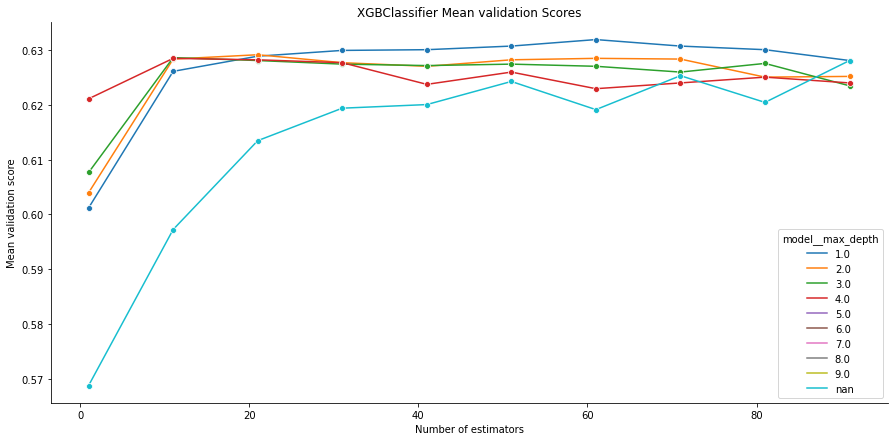

In [48]:
# plot the mean validation score for the best estimator
plt.figure(figsize=(15,7))
sns.lineplot(x='model__n_estimators', y='score', hue='model__max_depth', data=results_df, marker='o')
plt.ylabel('Mean validation score')
plt.xlabel('Number of estimators')
plt.title('XGBClassifier Mean validation Scores')
sns.despine()
plt.show()

We can see that the highest score was achieved by XGBClassifier with a max_depth of 1 and n_estimators of 61. Now we will fit our best estimator to the test set.

In [49]:
# fit to the test set
fittedgrid.score(X_test, y_test)

0.6403940886699507

In comparison with our baseline, which is 47%, we got a 64% accuracy rate. This highlights the importance of feature engineering for predicting future games. Based on the performance of the teams, we can predict the outcome of a LoL game with 17% more chances than a random guess.

We can use this model to place our bets and compare the odds provided by the bookmakers. Those games where we could obtain more profits are those that diverge from our predictions.

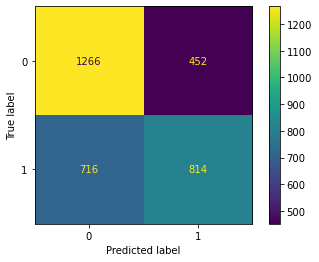

In [50]:
# plot confusion matrix
plot_confusion_matrix(fittedgrid, X_test, y_test);

### Based on our confusion matrix, we got the following four possible outcomes:
1. **True Positive (TP)**: Correctly predict that red team won. A total of 814 points.
2. **False Positive (FP)**: Incorrectly predict that red team won. A total of 452 points.
3. **True Negative (TN)**: Correctly predict that red team lost. A total of 1266 points. 
4. **False Negative (FN)**: Incorrectly predict that red team lost. A total of 716 points.

It is clear that there are many False Negatives, which is that we are incorrectly predicting that the red team lost. Recall score could be used to evaluate our model and look for ways to improve this score. There are many factors we can look at in eSports games to make a better prediction and generate new features that can help us better describe a winning team.

In the context of which class we prioritize to detect, we can select different scores to evaluate our model. For instance, if it is of greater interest to us to identify bad scores, we should reduce false positives and evaluate our model using precision scores. We can import the precision and recall scores from sklearn.metrics.

In [51]:
# print classification report
y_pred = fittedgrid.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.74      0.68      1718
           1       0.64      0.53      0.58      1530

    accuracy                           0.64      3248
   macro avg       0.64      0.63      0.63      3248
weighted avg       0.64      0.64      0.64      3248



As we can see from the chart above, the model has a low recall score for detecting that the red team won. Hence, we should improve it.

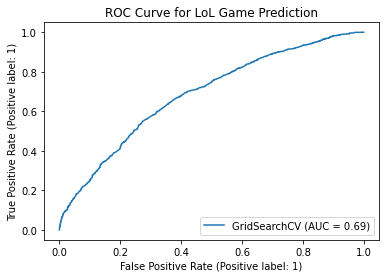

In [54]:
# plot ROC Curve
plot_roc_curve(fittedgrid, X_test, y_test)
plt.title('ROC Curve for LoL Game Prediction')
plt.show()

In [52]:
# AUC score
roc_auc = roc_auc_score(y_test, y_pred)
roc_auc

0.6344647599047379

According to the AUC score, which represents the area under the ROC curve, we scored 0.63. Therefore, our model outperforms random guessing by 13%.

# Conclusion

By building our model, we outperformed random guesses by 17%. We learned that feature engineering is crucial for building better models through this notebook. Now we have a model that can help us place bets more effectively. We still need to improve our model. In order to describe a winning team more precisely, more features can be added.

In the future, more eSports will be analyzed and more models will be developed. Compared to live games, online games have the advantage of digital information, which can be updated faster and with greater accuracy.